# <center>机器学习实践之遗传算法初体验</center>

前两天交流群里有朋友分享了遗传算法的文章，勾起了我久远的回忆：多年前看过一篇贴子，讲的是“内存中的进化”——通过计算机采用遗传算法模拟生物进化过程，使得一堆随机的三角形最终演变成了火狐浏览器的样子。经过一番搜索，居然找到了09年的原贴真身：[遗传算法：内存中的进化](http://songshuhui.net/archives/10462)

回想当年编程动手能力还比较捉急，开源世界里可用的组件也还很有限。而今老司机手痒得不行，随手抓过俩轮子来就敢发车。且把这场内存中的进化演绎一遍，感受自然的力量，兼怀逝去的光阴。

动手之前先温习一下理论知识。当年教我课程的先生虽还健在，我却只敢腆着脸问问度娘咯：[遗传算法](https://baike.baidu.com/item/遗传算法)
<blockquote>
遗传算法（Genetic Algorithm）是模拟达尔文生物进化论的自然选择和遗传学机理的生物进化过程的计算模型，是一种通过模拟自然进化过程搜索最优解的方法。遗传算法是从代表问题可能潜在的解集的一个种群（population）开始的，而一个种群则由经过基因（gene）编码的一定数目的个体(individual)组成。每个个体实际上是染色体(chromosome)带有特征的实体。染色体作为遗传物质的主要载体，即多个基因的集合，其内部表现（即基因型）是某种基因组合，它决定了个体的形状的外部表现，如黑头发的特征是由染色体中控制这一特征的某种基因组合决定的。因此，在一开始需要实现从表现型到基因型的映射即编码工作。由于仿照基因编码的工作很复杂，我们往往进行简化，如二进制编码，初代种群产生之后，按照适者生存和优胜劣汰的原理，逐代（generation）演化产生出越来越好的近似解，在每一代，根据问题域中个体的适应度（fitness）大小选择（selection）个体，并借助于自然遗传学的遗传算子（genetic operators）进行组合交叉（crossover）和变异（mutation），产生出代表新的解集的种群。这个过程将导致种群像自然进化一样的后生代种群比前代更加适应于环境，末代种群中的最优个体经过解码（decoding），可以作为问题近似最优解。
</blockquote>

简单抽象一下，程序的主要对象包括基因、染色体、个体和种群；遗传算法的核心逻辑如下面这段伪代码所示：
```python
init_population()
while not stoppable:
    compute_fitness()
    do_selection()
    do_crossover()
    do_mutations()
```
算法的输入包括适应度计算规则、种群大小、染色体长度、交叉概率、变异概率、进化停止规则等。盗一张图：
<img src="../datasets/ga/flow.jpg" alt="GA Flow" style="width: 400px; height: 400px; float: left" />

那就开动吧！

In [1]:
##-*-coding: utf-8;-*-##
import itertools as it
import logging
import matplotlib.pyplot as plt
import numpy as np
import os.path as P
import pathlib
import unittest as ut
import warnings

from PIL import Image, ImageDraw, ImageChops

In [2]:
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)-15s %(levelname)s: %(message)s', level=logging.INFO)

%matplotlib inline

In [3]:
class Gene(object):
    '''一个基因描述了一个小的透明三角形，要素是3个顶点的位置和颜色及透明度
    size: 图片的大小，假设是正方形的图片
    '''
    def __init__(self, size):
        self.size = size
        self.color = None
        self.location = None
        self.mutate()

    def mutate(self):
        # TODO: 检查3个随机点是否共线
        location = np.random.randint(0, self.size, (3, 2))
        self.location = tuple(map(tuple, location))
        # RGBA
        color = np.random.randint(0, 256, (3, )).tolist()
        color.append(64)
        self.color = tuple(color)
        return self

    def express(self, environment):
        environment.polygon(self.location, self.color)

    def __repr__(self):
        return str(self.location + (self.color,))


class Individual(object):
    def __init__(self, mother=None, father=None, isize=256, csize=256, mrate=0.01):
        if None not in (mother, father):
            dna = crossover(mother.dna, father.dna)
            dna = mutate(dna, mrate)
        else:
            dna = [Gene(isize) for i in range(csize)]
        self.dna = dna

        image = Image.new('RGB', (isize, isize), (255, 255, 255))
        draw = ImageDraw.Draw(image, 'RGBA')
        for gene in self.dna:
            gene.express(draw)
        del draw
        self.image = image

        self.fitness = None

        self.mother = mother
        self.father = father
        self.isize = isize
        self.csize = csize
        self.mrate = mrate

    def __lt__(self, other):
        return self.fitness < other.fitness

In [4]:
def crossover(m_genes, f_genes, part_limit=7):
    '''随机地从父母的DNA里选取片段组成子代的DNA
    m_genes: 母亲的基因组
    f_genes: 父亲的基因组
    part_limit: 一次随机选取的最大片段长度
    '''
    genes = list()
    limit = len(m_genes)
    parents = (m_genes, f_genes)
    which, start = 0, 0
    while start < limit:
        g = parents[which]
        count = np.random.randint(1, part_limit)
        p = start + count
        part = g[start:p]
        genes.extend(part)
        which, start = which ^ 0, p
    return genes


def mutate(genes, mrate):
    '''每个基因以`mrate`的概率发生突变
    '''
    index = np.argwhere(np.random.uniform(size=len(genes)) < mrate).reshape(-1)
    for i in index:
        g = genes[i]
        genes[i] = Gene(g.size)
    return genes


def fitness_rms(perfect, individual):
    '''采用 root-mean-squares difference方案计算2张图片的相似度(
    #http://code.activestate.com/recipes/577630-comparing-two-images)
    TODO: 图像特征刻画实现是否可以参考这篇贴子里的方案(
    #https://www.pyimagesearch.com/2014/12/01/complete-guide-building-image-search-engine-python-opencv)
    '''
    diff = ImageChops.difference(perfect, individual) # 逐像素比较2张图片的差异
    counts = np.array(diff.histogram()) # 逐channel逐[0, 255]颜色强度值的统计像素个数
    lights = np.tile(range(256), 3)

    rms = np.sqrt(np.average(lights ** 2, weights=counts))
    return np.e ** -rms


def fitness_hsv(perfect, individual):
    return np.e ** -np.linalg.norm(perfect - individual)


def select(population, nelites):
    '''根据`population`中个体适应度的大小选出`n_elites`对个体以产生更多后代
    '''
    fitnesses = np.array([i.fitness for i in population])
    fitnesses = fitnesses / fitnesses.sum()
    elites = np.random.choice(population, (nelites, 2), True, fitnesses)
    return elites


def image_hsv_features(image, masks):
    features = list()

    image_array = [np.asarray(layer) for layer in image.convert('HSV').split()]
    for i, m in it.product(range(3), masks):
        hist, _ = np.histogram(image_array[i], 10, (0, 256), True, m)
        features.extend(hist)

    return np.array(features)


def region_masks(w, h):
    x, y = w * 0.5, h * 0.5

    corners = (
        (0, 0, x, y),
        (x, 0, w, y),
        (x, y, w, h),
        (0, y, x, h),
    )

    axesX, axesY = w * 0.55, h * 0.55

    masks = list()

    ellipse = Image.new('L', (w, h))
    draw = ImageDraw.Draw(ellipse)
    draw.ellipse(((w - axesX) * .5, (h - axesY) * .5, (w + axesX) * .5, (h + axesY) * .5), 'white')
    del draw

    masks.append(ellipse)

    for xy in corners:
        rectangle = Image.new('L', (w, h))
        draw = ImageDraw.Draw(rectangle)
        draw.rectangle(xy, 'white')
        del draw
        mask = ImageChops.subtract(rectangle, ellipse)
        masks.append(mask)

    ma = [np.asarray(m).clip(0, 1) for m in masks]
    return ma


def evolve(target_image,
           population_size, elites_rate, nchildren, generations,
           chromosome_size, mutation_rate,
           verbosity=1):
    # 更特殊的火狐进化场景
    class Firefox(Individual):
        perfect = Image.open(target_image).convert('RGB')
        # masks = region_masks(*perfect.size)
        # perefct_features = image_hsv_features(perfect, masks)

        def __init__(self, mother=None, father=None):
            super(Firefox, self).__init__(mother, father,
                                          self.perfect.size[0], chromosome_size,
                                          mutation_rate)
            # hsv_features = image_hsv_features(self.image, self.masks)
            # self.fitness = fitness_hsv(self.perefct_features, hsv_features)
            self.fitness = fitness_rms(self.perfect, self.image)

    images_path = pathlib.Path(P.dirname(P.realpath(target_image)))

    def dump_image(image, name_id):
        path = images_path.joinpath(str(name_id)).with_suffix('.png')
        path = str(path)
        image.save(path)

    def plot_images():
        images = [Image.open(f) for f in images_path.glob('*.png')]
        s = 2
        w = 4.
        h = np.ceil(len(images) / w)
        fig = plt.figure(figsize=(w * s, h * s))
        for i, img in enumerate(images, 1):
            title = P.basename(img.filename).rstrip('.png')
            ax = fig.add_subplot(h, w, i)
            ax.set_title(title)
            ax.axis('off')
            ax.imshow(img)

    nelites = int(population_size * elites_rate)

    # 初始化种群
    population = [Firefox() for i in range(population_size)]

    # 迭代进化
    for g in range(generations):
        # 计算个体的适应度，保持种群大小
        population.sort(reverse=True)
        population = population[:population_size]

        if g % (500 / verbosity) == 0:
            logging.info('%d generations passed', g)
        if g % (1000 / verbosity) == 0:
            dump_image(population[0].image, g)
            logging.info('generation %d dumped', g)

        # 选择有生育权的精英
        elites = select(population, nelites)
        # 繁殖：交叉和变异
        children = [Firefox(m, f) for (m, f), _ in it.product(elites, range(nchildren))]
        population.extend(children)

    # 最佳效果
    best = max(population)
    dump_image(best.image, 'best')

    plot_images()

    return best

2018-03-29 09:17:44,359 INFO: 0 generations passed
2018-03-29 09:17:44,375 INFO: generation 0 dumped
2018-03-29 09:19:45,509 INFO: 500 generations passed
2018-03-29 09:21:39,276 INFO: 1000 generations passed
2018-03-29 09:21:39,288 INFO: generation 1000 dumped
2018-03-29 09:23:31,436 INFO: 1500 generations passed
2018-03-29 09:25:07,573 INFO: 2000 generations passed
2018-03-29 09:25:07,585 INFO: generation 2000 dumped
2018-03-29 09:26:41,021 INFO: 2500 generations passed
2018-03-29 09:27:57,159 INFO: 3000 generations passed
2018-03-29 09:27:57,169 INFO: generation 3000 dumped
2018-03-29 09:29:12,012 INFO: 3500 generations passed
2018-03-29 09:30:27,063 INFO: 4000 generations passed
2018-03-29 09:30:27,071 INFO: generation 4000 dumped
2018-03-29 09:31:41,701 INFO: 4500 generations passed
2018-03-29 09:32:56,222 INFO: 5000 generations passed
2018-03-29 09:32:56,232 INFO: generation 5000 dumped
2018-03-29 09:34:11,123 INFO: 5500 generations passed
2018-03-29 09:35:25,888 INFO: 6000 genera

CPU times: user 1h 19min 23s, sys: 13 s, total: 1h 19min 36s
Wall time: 1h 19min 58s


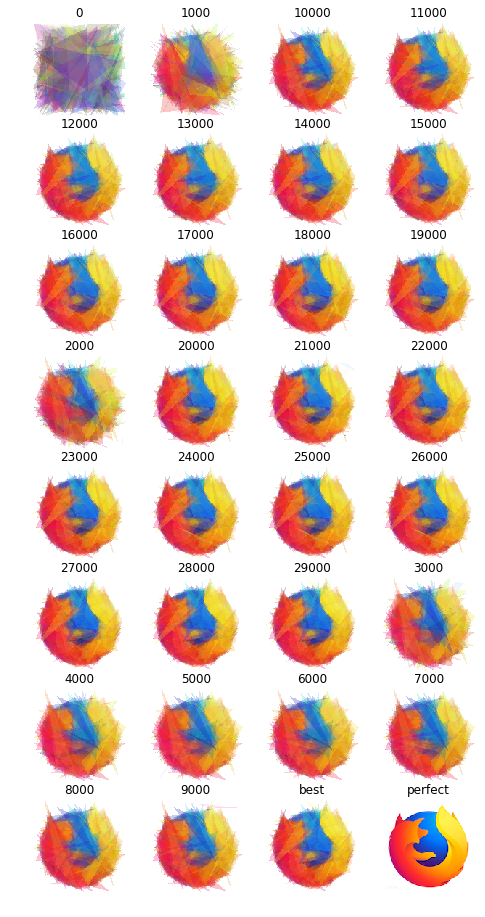

In [5]:
%time best = evolve('../datasets/ga/firefox/perfect.png', 32, 0.35, 5, 30000, 256, 0.01)

笔记本性能较差，只训练了30000代，最好的进化结果粗看起来也还像那么回事儿。墙上的时钟只扫过了约一圈半，却让人有了一种“百代过客”之感。都说
机器学习 = 表示 + 评估 + 优化：这里的表示借鉴的是自然之法，个体的表象通过扁平的DNA结构来编码；评估手段更是简单粗暴，
只是逐像素对比两张图片的差异；优化思路同样借鉴自然之义，却也只是稀松无奇的常识。不同于统计学习流派劈头盖脸的“数学常识”，遗传算法的概念与过程总是更加自然、直观，本例也绝对是入门机器学习技术，体验机构与算法之美的优秀案例。